<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Compare-base-data" data-toc-modified-id="Compare-base-data-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Compare base data</a></span></li></ul></li><li><span><a href="#Tour-Scheduling" data-toc-modified-id="Tour-Scheduling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tour Scheduling</a></span></li><li><span><a href="#Tour-OD-Choice" data-toc-modified-id="Tour-OD-Choice-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Tour OD Choice</a></span><ul class="toc-item"><li><span><a href="#Tour-Origin" data-toc-modified-id="Tour-Origin-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Tour Origin</a></span></li><li><span><a href="#Tour-Destination-p-MSA-by-Origin" data-toc-modified-id="Tour-Destination-p-MSA-by-Origin-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Tour Destination p-MSA by Origin</a></span></li><li><span><a href="#Tour-Distance-by-Tour-Mode" data-toc-modified-id="Tour-Distance-by-Tour-Mode-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Tour Distance by Tour Mode</a></span></li><li><span><a href="#Tour-Distance-by-Intra-MAZ-Tour-Flag" data-toc-modified-id="Tour-Distance-by-Intra-MAZ-Tour-Flag-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Tour Distance by Intra-MAZ Tour Flag</a></span></li></ul></li><li><span><a href="#Tour-Mode-Choice" data-toc-modified-id="Tour-Mode-Choice-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tour Mode Choice</a></span></li><li><span><a href="#Stop-Frequency" data-toc-modified-id="Stop-Frequency-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stop Frequency</a></span></li><li><span><a href="#Trip-Purpose" data-toc-modified-id="Trip-Purpose-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Trip Purpose</a></span><ul class="toc-item"><li><span><a href="#Trips-per-Tour-by-Trip-Purpose" data-toc-modified-id="Trips-per-Tour-by-Trip-Purpose-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Trips per Tour by Trip Purpose</a></span></li></ul></li><li><span><a href="#Trip-Scheduling" data-toc-modified-id="Trip-Scheduling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Trip Scheduling</a></span></li><li><span><a href="#Trip-Destination" data-toc-modified-id="Trip-Destination-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Trip Destination</a></span><ul class="toc-item"><li><span><a href="#Trip-ODs" data-toc-modified-id="Trip-ODs-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Trip ODs</a></span></li><li><span><a href="#Trip-Distance" data-toc-modified-id="Trip-Distance-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Trip Distance</a></span></li></ul></li><li><span><a href="#Trip-Mode" data-toc-modified-id="Trip-Mode-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Trip Mode</a></span><ul class="toc-item"><li><span><a href="#Trip-Mode-by-Tour-Mode" data-toc-modified-id="Trip-Mode-by-Tour-Mode-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Trip Mode by Tour Mode</a></span></li><li><span><a href="#Trip-Distance-by-Trip-Mode" data-toc-modified-id="Trip-Distance-by-Trip-Mode-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Trip Distance by Trip Mode</a></span></li></ul></li></ul></div>

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Imports 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import openmatrix as omx
from matplotlib import pyplot as plt
%matplotlib inline

### Load data

In [2]:
ctramp_trips = pd.read_csv('../../../../../../projects/sandag-cb/output/crossBorderTrips.csv')
ctramp_tours = pd.read_csv('../../../../../../projects/sandag-cb/output/crossBorderTours.csv')

mode_ids = {1: 'DRIVEALONE', 2:'SHARED2', 3:'SHARED3', 4:'WALK', 6:'WALK_TRANSIT', 10:'TAXI', 11:'TNC_SINGLE', 12:'TNC_SHARED'}
purpose_ids = {-1: 'home', 0:'work', 1:'school', 2:'cargo', 3:'shop', 4:'visit', 5:'other'}

ctramp_tours['tour_mode'] = ctramp_tours['tourMode'].map(mode_ids)
ctramp_trips['trip_mode'] = ctramp_trips['tripMode'].map(mode_ids)
ctramp_tours['tour_purpose'] = ctramp_tours['purpose'].map(purpose_ids)
ctramp_trips['orig_purpose'] = ctramp_trips['originPurp'].map(purpose_ids)
ctramp_trips['dest_purpose'] = ctramp_trips['destPurp'].map(purpose_ids)

In [3]:
skims = omx.open_file('data/traffic_skims_xborder_EA.omx')
mazs = pd.read_csv('data/mazs_xborder.csv')
mazs.set_index('MAZ', inplace=True)
maz_to_taz = mazs['TAZ']

In [4]:
ctramp_trips['originTAZ'] = ctramp_trips['originMGRA'].map(maz_to_taz)
ctramp_trips['destinationTAZ'] = ctramp_trips['destinationMGRA'].map(maz_to_taz)
ctramp_tours['originTAZ'] = ctramp_tours['originMGRA'].map(maz_to_taz)
# ctramp_tours['destinationTAZ'] = ctramp_tours['destinationMGRA'].map(maz_to_taz)
ctramp_trips = ctramp_trips.merge(ctramp_tours, left_on='tourID', right_on='id', suffixes=('', '_tour'))

In [5]:
ctramp_trips['source'] = 'ctramp'
ctramp_tours['source'] = 'ctramp'

In [6]:
asim_trips = pd.read_csv('output/final_trips.csv')
asim_tours = pd.read_csv('output/final_tours.csv')

In [7]:
asim_trips = asim_trips.merge(asim_tours, left_on='tour_id', right_on='tour_id', suffixes=('', '_tour'))

In [8]:
asim_tours['dest_taz'] = asim_tours['destination'].map(maz_to_taz)
asim_tours['orig_taz'] = asim_tours['origin'].map(maz_to_taz)
asim_trips['dest_taz'] = asim_trips['destination'].map(maz_to_taz)
asim_trips['orig_taz'] = asim_trips['origin'].map(maz_to_taz)

In [9]:
asim_trips['source'] = 'asim'
asim_tours['source'] = 'asim'

In [67]:
asim_trips['orig_taz'].min()

13

In [69]:
asim_tours['orig_taz'].unique()

array([4993, 4989, 4831], dtype=int64)

### Compare base data

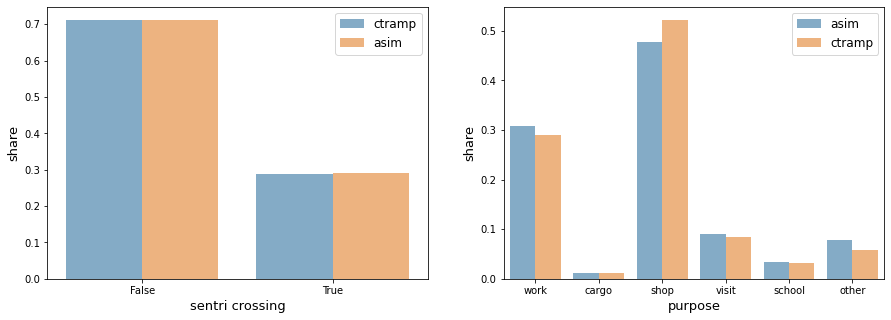

In [10]:
fig, axarr = plt.subplots(1,2,figsize=(15,5))
sentri_shares = pd.DataFrame((
    (ctramp_tours['sentri'].value_counts() / len(ctramp_tours)),
    (asim_tours['sentri_crossing'].astype(bool).value_counts() / len(asim_tours))))
sentri_shares.index = ['ctramp', 'asim']
sentri_shares.index.name = 'source'
sentri_shares.reset_index(inplace=True)
sentri_shares = sentri_shares.melt(id_vars='source', value_name='share', var_name='sentri crossing')

asim_purpose_shares = pd.DataFrame(asim_tours['tour_type'].value_counts(sort=False) / asim_tours.shape[0]).reset_index()
asim_purpose_shares.columns = ['purpose', 'share']
asim_purpose_shares['source'] = 'asim'
ctramp_purpose_shares = pd.DataFrame(ctramp_tours['tour_purpose'].value_counts(sort=False) / ctramp_tours.shape[0]).reset_index()
ctramp_purpose_shares.columns = ['purpose', 'share']
ctramp_purpose_shares['source'] = 'ctramp'
purpose_shares = pd.concat((asim_purpose_shares, ctramp_purpose_shares))

sns.barplot(data=sentri_shares, x='sentri crossing', y='share', hue='source', ax=axarr[0],alpha=0.6)
sns.barplot(data=purpose_shares, x='purpose', y='share', hue='source', ax=axarr[1], alpha=0.6)

for ax in axarr:
    ax.legend(fontsize=12)
    ax.set_ylabel('share', fontsize=13)
    ax.set_xticklabels(labels=ax.get_xticklabels(),fontsize=10)
    ax.set_xlabel(ax.get_xlabel(), fontsize=13)

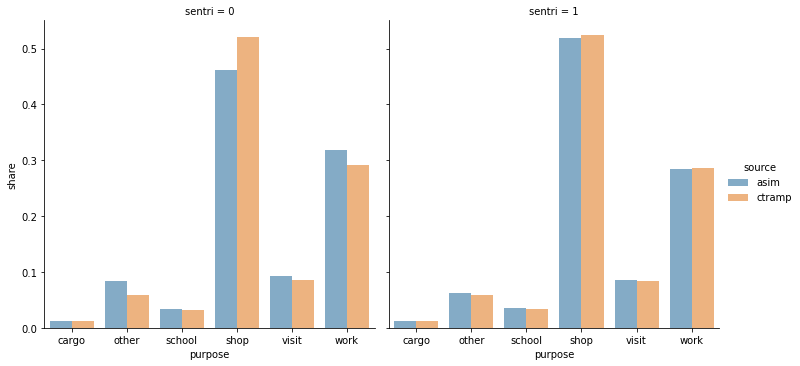

In [11]:
asim_purp_poe_shares = asim_tours.groupby(['sentri_crossing','tour_type'])['tour_id'].count().reset_index(level='tour_type').merge(
    asim_tours.groupby('sentri_crossing').count().rename(
        columns={'tour_id':'sentri_total'})[['sentri_total']], left_index=True, right_index=True).reset_index()
asim_purp_poe_shares['share'] = asim_purp_poe_shares['tour_id'] / asim_purp_poe_shares['sentri_total']
asim_purp_poe_shares.columns = ['sentri','purpose','count','total','share']
asim_purp_poe_shares['source'] = 'asim'

ctramp_purp_poe_shares = ctramp_tours.groupby(['sentri','tour_purpose'])['id'].count().reset_index(level='tour_purpose').merge(
    ctramp_tours.groupby('sentri').count().rename(
        columns={'id':'sentri_total'})[['sentri_total']], left_index=True, right_index=True).reset_index()
ctramp_purp_poe_shares['share'] = ctramp_purp_poe_shares['id'] / ctramp_purp_poe_shares['sentri_total']
ctramp_purp_poe_shares.columns = ['sentri','purpose','count','total','share']
ctramp_purp_poe_shares['source'] = 'ctramp'
purp_poe_shares = pd.concat((asim_purp_poe_shares,ctramp_purp_poe_shares))

sns.catplot(data=purp_poe_shares, x='purpose', y='share', hue='source', col='sentri',kind='bar', alpha=0.6)

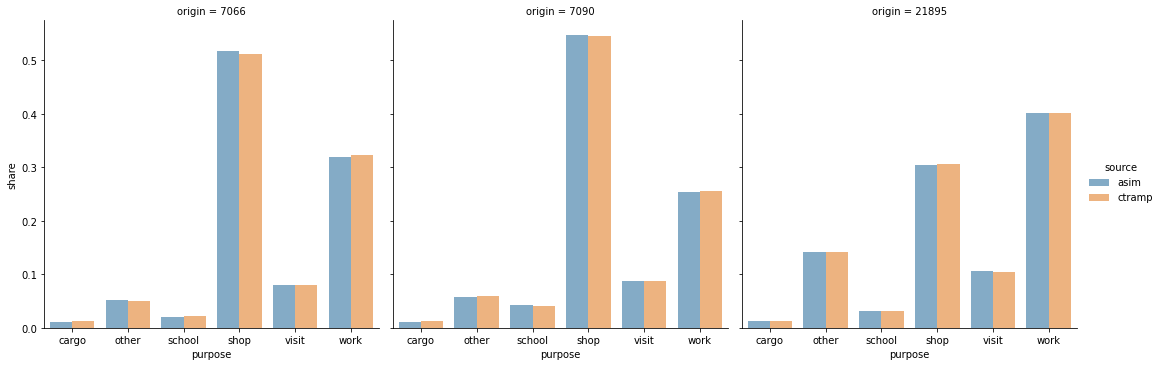

In [12]:
asim_purp_poe_shares = asim_tours.groupby(['origin','tour_type'])['tour_id'].count().reset_index(level='tour_type').merge(
    asim_tours.groupby('origin').count().rename(
        columns={'tour_id':'origin_total'})[['origin_total']], left_index=True, right_index=True).reset_index()
asim_purp_poe_shares['share'] = asim_purp_poe_shares['tour_id'] / asim_purp_poe_shares['origin_total']
asim_purp_poe_shares.columns = ['origin','purpose','count','total','share']
asim_purp_poe_shares['source'] = 'asim'

ctramp_purp_poe_shares = ctramp_tours.groupby(['originMGRA','tour_purpose'])['id'].count().reset_index(level='tour_purpose').merge(
    ctramp_tours.groupby('originMGRA').count().rename(
        columns={'id':'origin_total'})[['origin_total']], left_index=True, right_index=True).reset_index()
ctramp_purp_poe_shares['share'] = ctramp_purp_poe_shares['id'] / ctramp_purp_poe_shares['origin_total']
ctramp_purp_poe_shares.columns = ['origin','purpose','count','total','share']
ctramp_purp_poe_shares['source'] = 'ctramp'
purp_poe_shares = pd.concat((asim_purp_poe_shares,ctramp_purp_poe_shares))

sns.catplot(data=purp_poe_shares, x='purpose', y='share', hue='source', col='origin',kind='bar', alpha=0.6)

## Tour Scheduling 

Text(0.5, 0, 'tour departure hour')

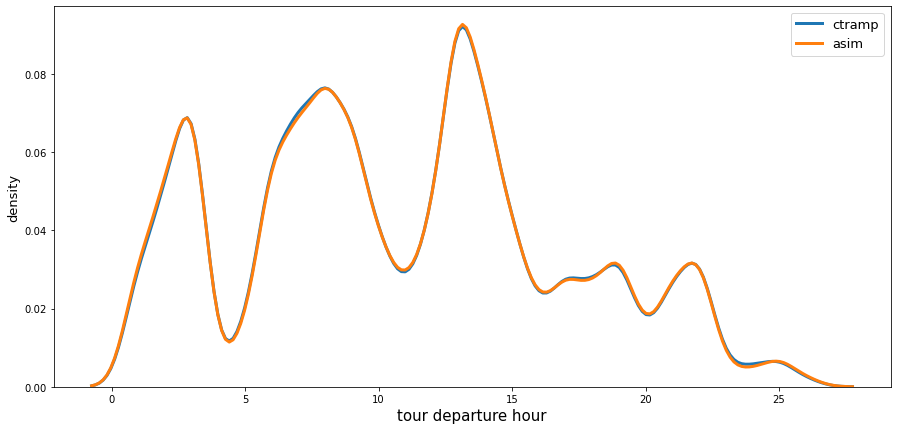

In [13]:
fig, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(data=ctramp_tours, x='departTime', ax=ax, label='ctramp', alpha=0.4, lw=3, )
sns.kdeplot(data=asim_tours, x='start', ax=ax, label='asim', alpha=0.4, lw=3)
ax.legend(fontsize=13)
ax.set_ylabel('density', fontsize=13)
ax.set_xlabel('tour departure hour', fontsize=15)

## Tour OD Choice 

### Tour Origin

Text(0.5, 0, 'POE')

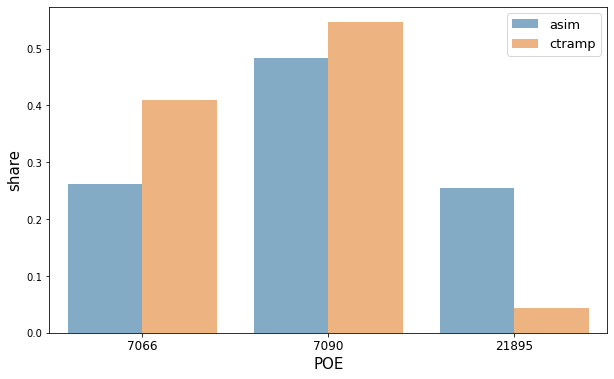

In [14]:
asim_poe_shares = pd.DataFrame(asim_tours['origin'].value_counts(sort=False) / asim_tours.shape[0]).reset_index()
asim_poe_shares.columns = ['poe', 'share']
asim_poe_shares['source'] = 'asim'
ctramp_poe_shares = pd.DataFrame(ctramp_tours['originMGRA'].value_counts(sort=False) / ctramp_tours.shape[0]).reset_index()
ctramp_poe_shares.columns = ['poe', 'share']
ctramp_poe_shares['source'] = 'ctramp'
poe_shares = pd.concat((asim_poe_shares, ctramp_poe_shares))
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=poe_shares, x='poe', y='share', hue='source',ax=ax, alpha=0.6)

ax.legend(fontsize=13)
ax.set_ylabel('share', fontsize=15)
ax.set_xticklabels(labels=ax.get_xticklabels(),fontsize=12)
ax.set_xlabel('POE', fontsize=15)

### Tour Destination p-MSA by Origin 

In [15]:
asim_tours['dest_pseudomsa'] = asim_tours['destination'].map(mazs['pseudomsa'])
ctramp_tours['dest_pseudomsa'] = ctramp_tours['destinationMGRA'].map(mazs['pseudomsa'])
asim_tour_ods = asim_tours.groupby(['origin','dest_pseudomsa'])['tour_id'].count().reset_index()
ctramp_tour_ods = ctramp_tours.groupby(['originMGRA','dest_pseudomsa'])['id'].count().reset_index()
ctramp_tour_ods.rename(columns={'originMGRA': 'origin'}, inplace=True)

all_ods = pd.merge(
    asim_tour_ods, ctramp_tour_ods, left_on=['origin','dest_pseudomsa'],
    right_on=['origin','dest_pseudomsa'], how='outer')
all_ods.rename(columns={'id':'ctramp', 'tour_id':'asim'}, inplace=True)
all_ods['asim'] = all_ods['asim'].fillna(0)
all_ods['ctramp'] = all_ods['ctramp'].fillna(0)

all_ods = all_ods.melt(id_vars=['origin','dest_pseudomsa'], var_name='source', value_name='num_tours')

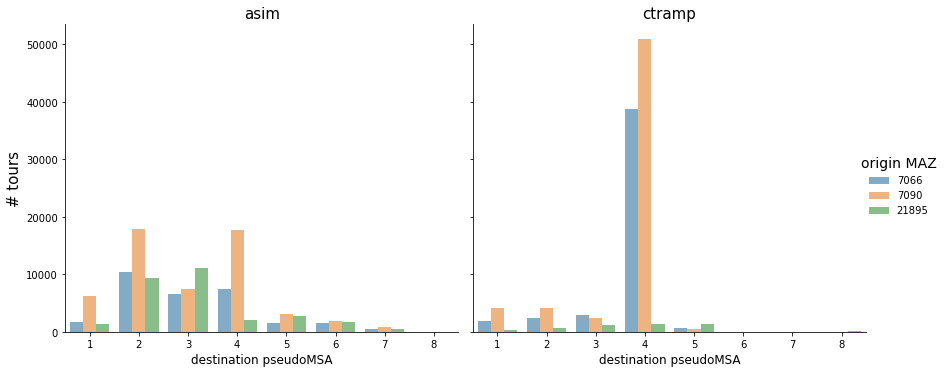

In [16]:
g = sns.catplot(
    data=all_ods, x='dest_pseudomsa', y='num_tours', hue='origin', kind='bar', col='source',
    aspect=1.2, legend_out=True, alpha=0.6)
g._legend.set_title('origin MAZ', prop={'size':14})
# g.fig.get_axes()[0].set_yscale('log')
g.fig.get_axes()[0].set_title('asim', fontsize=15)
g.fig.get_axes()[1].set_title('ctramp', fontsize=15)
g.axes[0,0].set_ylabel('# tours', fontsize=15)
g.axes[0,0].set_xlabel('destination pseudoMSA', fontsize=12)
_ = g.axes[0,1].set_xlabel('destination pseudoMSA', fontsize=12)

### Tour Distance by Tour Mode

In [17]:
asim_tours['intra_maz'] = asim_tours['origin'] == asim_tours['destination']
ctramp_tours['intra_maz'] = ctramp_tours['originMGRA'] == ctramp_tours['destinationMGRA']

In [18]:
asim_uniq_ods = asim_tours[['orig_taz','dest_taz']].drop_duplicates()
asim_uniq_ods['sov_dist'] = skims['SOV_NT_M_DIST__EA'][asim_uniq_ods['orig_taz'].values - 1, asim_uniq_ods['dest_taz'].values - 1]
asim_tours_w_dist = asim_tours.merge(asim_uniq_ods, left_on=['orig_taz', 'dest_taz'], right_on=['orig_taz','dest_taz'])

ctramp_uniq_ods = ctramp_tours[['originTAZ','destinationTAZ']].drop_duplicates()
ctramp_uniq_ods['sov_dist'] = skims['SOV_NT_M_DIST__EA'][ctramp_uniq_ods['originTAZ'].values - 1, ctramp_uniq_ods['destinationTAZ'].values - 1]
ctramp_tours_w_dist = ctramp_tours.merge(ctramp_uniq_ods, left_on=['originTAZ','destinationTAZ'], right_on=['originTAZ','destinationTAZ'])
ctramp_tours_w_dist['origin'] = ctramp_tours_w_dist['originMGRA']

In [19]:
tour_dists = pd.concat((
    asim_tours_w_dist[['sov_dist','source','intra_maz', 'origin', 'tour_mode']],
    ctramp_tours_w_dist[['sov_dist','source','intra_maz', 'origin', 'tour_mode']]), ignore_index=True)

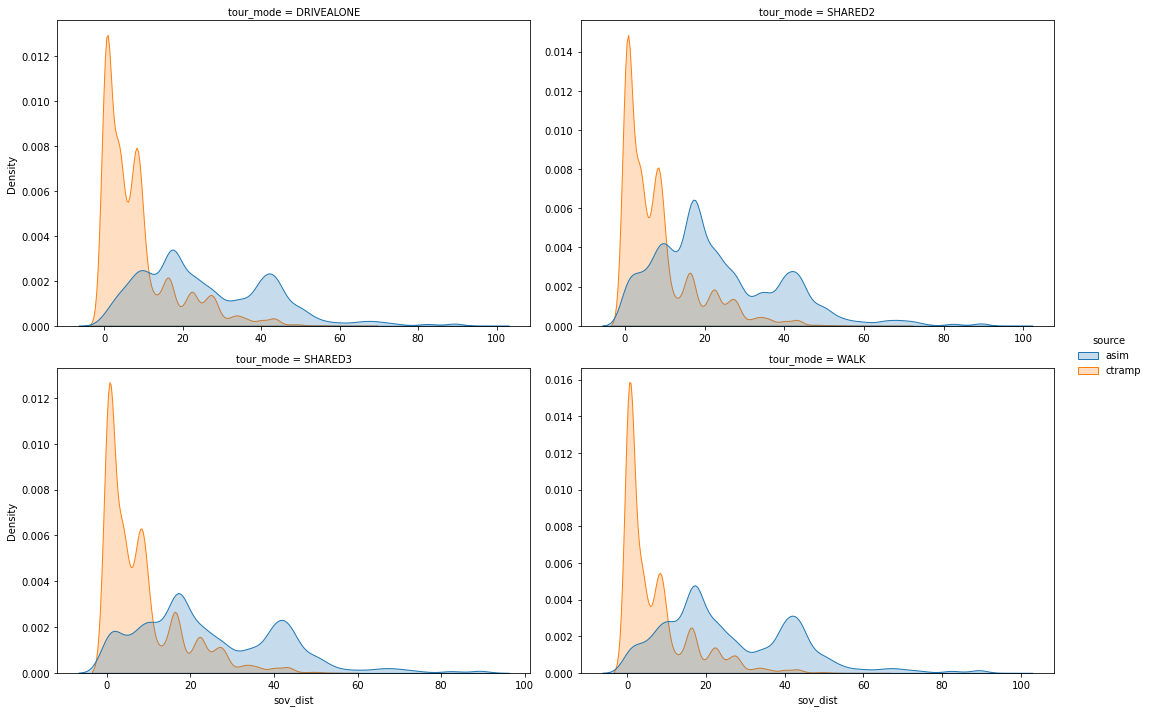

In [20]:
sns.displot(
    data=tour_dists, x='sov_dist', col='tour_mode',col_wrap=2,hue='source', kind='kde', fill=True, aspect=1.5,
    facet_kws={'sharex': False, 'sharey': False, 'despine':False})

### Tour Distance by Intra-MAZ Tour Flag

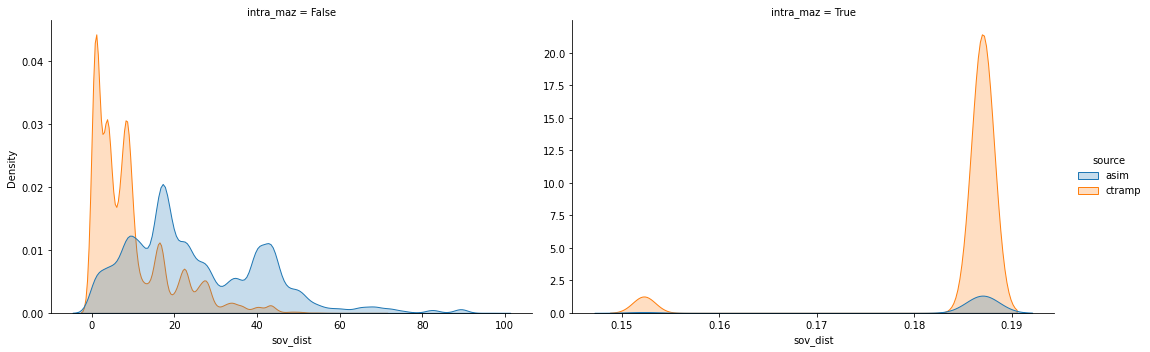

In [21]:
sns.displot(
    data=tour_dists, x='sov_dist', col='intra_maz',hue='source', kind='kde', fill=True, aspect=1.5,
    facet_kws={'sharex': False, 'sharey': False})

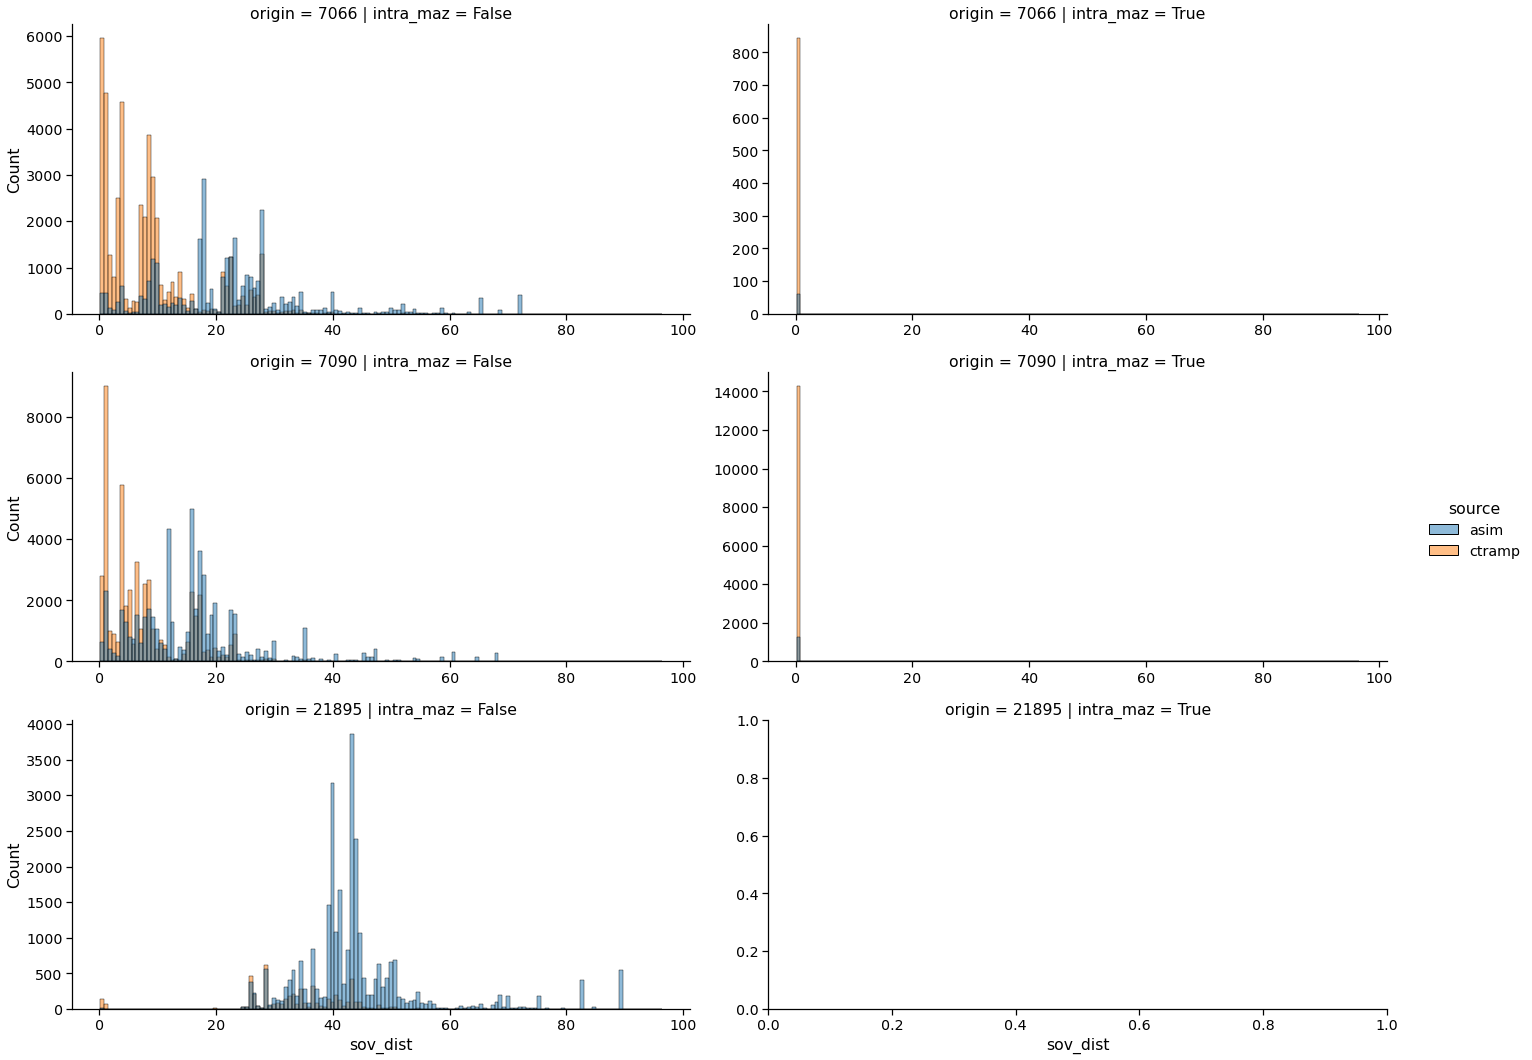

In [22]:
with sns.plotting_context("notebook",font_scale=1.3):
    sns.displot(
        data=tour_dists, x='sov_dist', col='intra_maz', row='origin', hue='source', kind='hist',aspect=2,
        facet_kws={'sharex': False, 'sharey': False})

## Tour Mode Choice

Text(0.5, 0, 'tour mode')

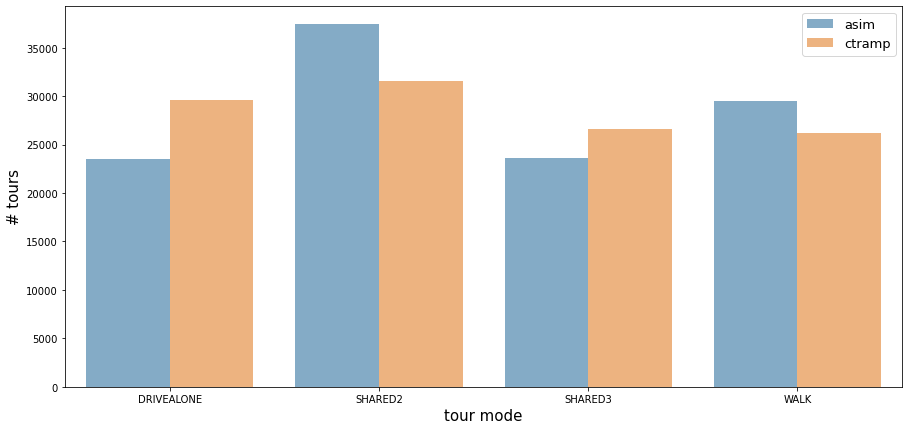

In [23]:
fig, ax = plt.subplots(figsize=(15,7))
tour_mode = asim_tours.groupby('tour_mode')['tour_id'].count()
tour_mode = pd.merge(tour_mode, ctramp_tours.groupby('tour_mode')['id'].count(), left_index=True, right_index=True).reset_index()
tour_mode.columns = ['tour_mode','asim','ctramp']
tour_mode = tour_mode.melt(id_vars='tour_mode',var_name='source',value_name='num_tours')
sns.barplot(
    data=tour_mode, x='tour_mode', y='num_tours', order=['DRIVEALONE','SHARED2','SHARED3','WALK'],
    hue='source', ax=ax, alpha=0.6)
ax.legend(fontsize=13)
ax.set_ylabel('# tours', fontsize=15)
ax.set_xlabel('tour mode', fontsize=15)

## Stop Frequency

In [24]:
asim_tpt = asim_trips.groupby(['tour_id'])['trip_id'].count().value_counts().reset_index()
asim_tpt.columns = ['# trips', '# tours']
asim_tpt['source'] = 'asim'

In [25]:
ctramp_tpt = ctramp_trips.groupby(['tourID'])['tripID'].count().value_counts().reset_index()
ctramp_tpt.columns = ['# trips', '# tours']
ctramp_tpt['source'] = 'ctramp'

In [26]:
all_tpt = pd.concat([asim_tpt,ctramp_tpt])

Text(0.5, 0, 'trips per tour')

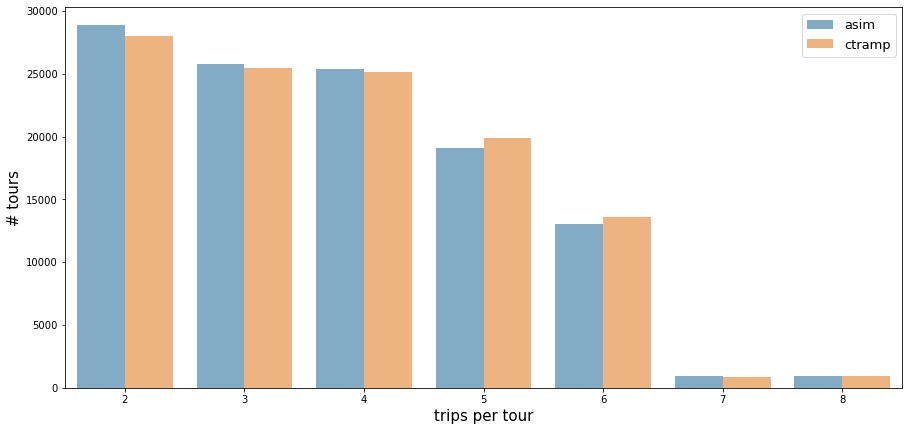

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(data=all_tpt, x='# trips', y='# tours', hue='source', ax=ax, alpha=0.6)
ax.legend(fontsize=13)
ax.set_ylabel('# tours', fontsize=15)
ax.set_xlabel('trips per tour', fontsize=15)

## Trip Purpose 

In [28]:
asim_purp = asim_trips.groupby(['purpose'])['trip_id'].count().reset_index()
asim_purp.columns = ['purpose', '# trips']
asim_purp['source'] = 'asim'

In [29]:
ctramp_purp = ctramp_trips.groupby(['dest_purpose'])['tripID'].count().reset_index()
ctramp_purp.columns = ['purpose', '# trips']
ctramp_purp['source'] = 'ctramp'

In [30]:
all_purp = pd.concat([asim_purp, ctramp_purp])

Text(0.5, 0, 'trip purpose')

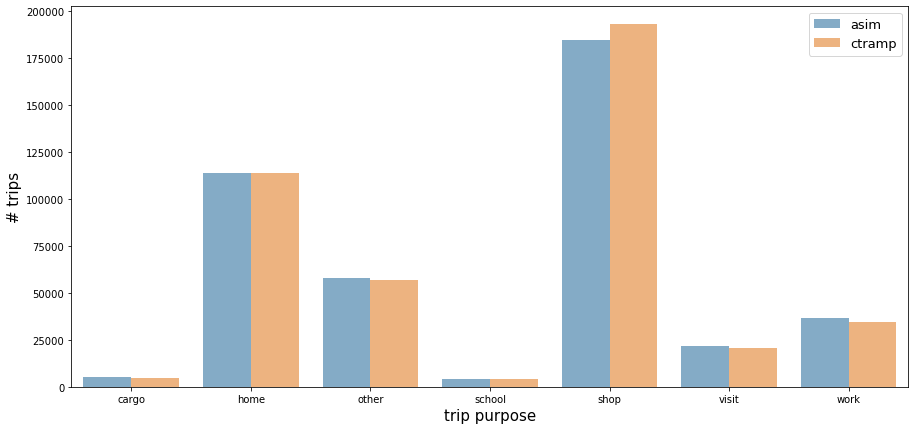

In [31]:
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(data=all_purp, x='purpose', y='# trips', hue='source', ax=ax, alpha=0.6)
ax.legend(fontsize=13)
ax.set_ylabel('# trips', fontsize=15)
ax.set_xlabel('trip purpose', fontsize=15)

### Trips per Tour by Trip Purpose 

In [32]:
asim_tpt = asim_trips.groupby(['tour_id', 'purpose'])['trip_id'].count().reset_index()
asim_tpt.rename(columns={'trip_id': 'trips per tour', 'tour_id': '# tours', 'purpose': 'trip purpose'}, inplace=True)
asim_tpt = asim_tpt.groupby(['trip purpose', 'trips per tour']).count().reset_index()
asim_tpt['source'] = 'asim'

In [33]:
ctramp_tpt = ctramp_trips.groupby(['tourID', 'dest_purpose'])['tripID'].count().reset_index()
ctramp_tpt.rename(columns={'tripID': 'trips per tour', 'tourID': '# tours', 'dest_purpose': 'trip purpose'}, inplace=True)
ctramp_tpt = ctramp_tpt.groupby(['trip purpose', 'trips per tour']).count().reset_index()
ctramp_tpt['source'] = 'ctramp'

In [34]:
all_tpt = pd.concat([asim_tpt, ctramp_tpt])

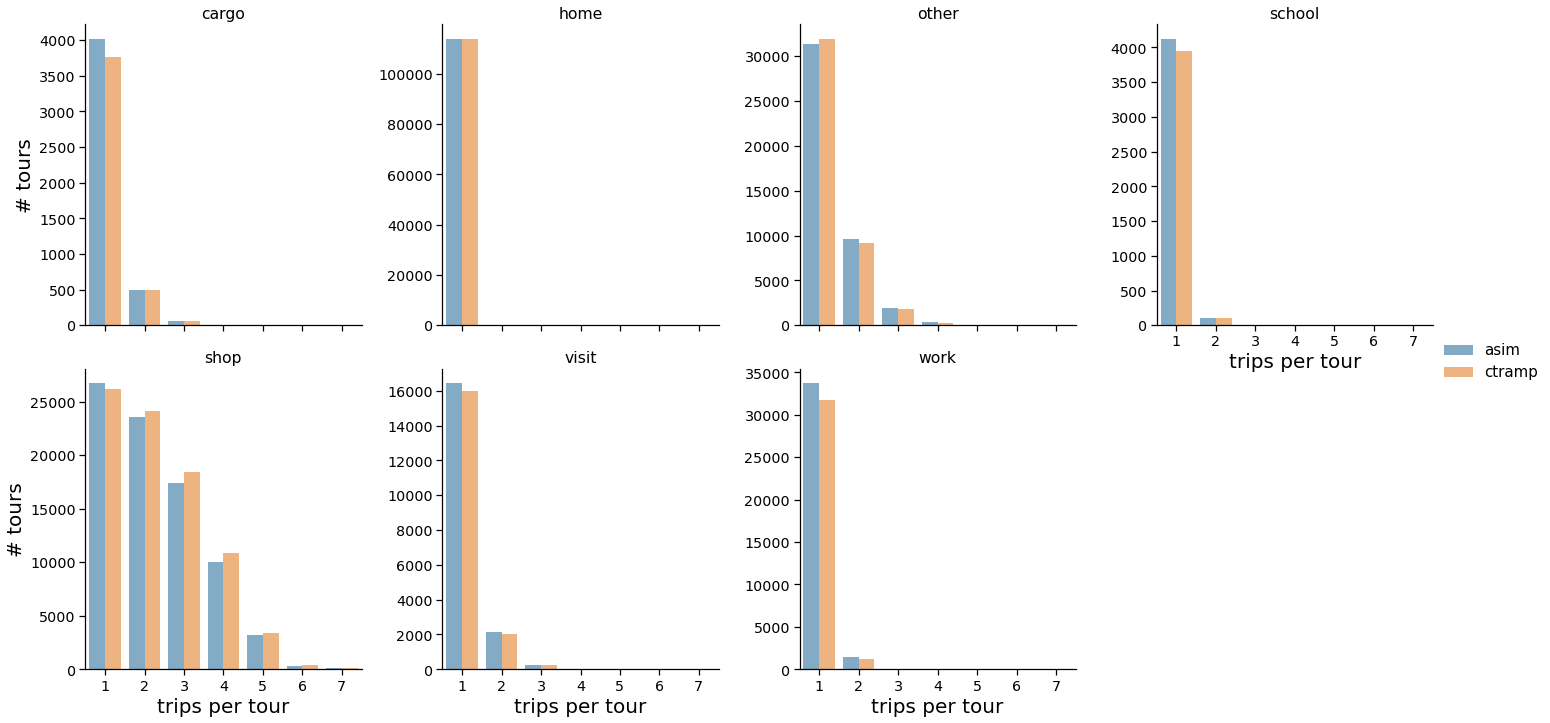

In [35]:
with sns.plotting_context("notebook",font_scale=1.3):
    g = sns.catplot(
        data=all_tpt, x='trips per tour', y='# tours', kind='bar', hue='source', col='trip purpose',
        col_wrap=4, sharey=False, alpha=0.6)
    g._legend.set_title('')
    plt.setp(g._legend.get_texts(), fontsize=15)
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("trips per tour", "# tours", fontsize=20)

## Trip Scheduling 

Text(0.5, 0, 'trip departure hour (outbound)')

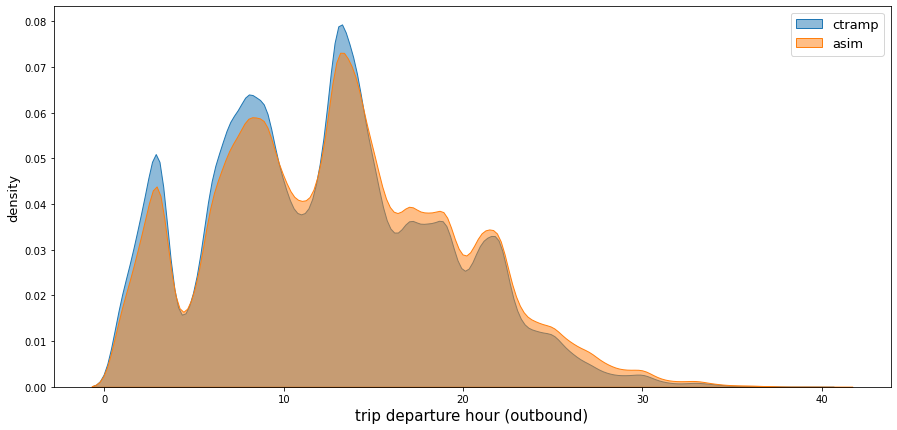

In [36]:
fig, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(data=ctramp_trips[~ctramp_trips['inbound']], x='period', ax=ax, label='ctramp', alpha=0.5, shade=True)
sns.kdeplot(data=asim_trips[asim_trips['outbound']], x='depart', ax=ax, label='asim', alpha=0.5, shade=True)
ax.legend(fontsize=13)
ax.set_ylabel('density', fontsize=13)
ax.set_xlabel('trip departure hour (outbound)', fontsize=15)

Text(0.5, 0, 'trip departure hour (inbound)')

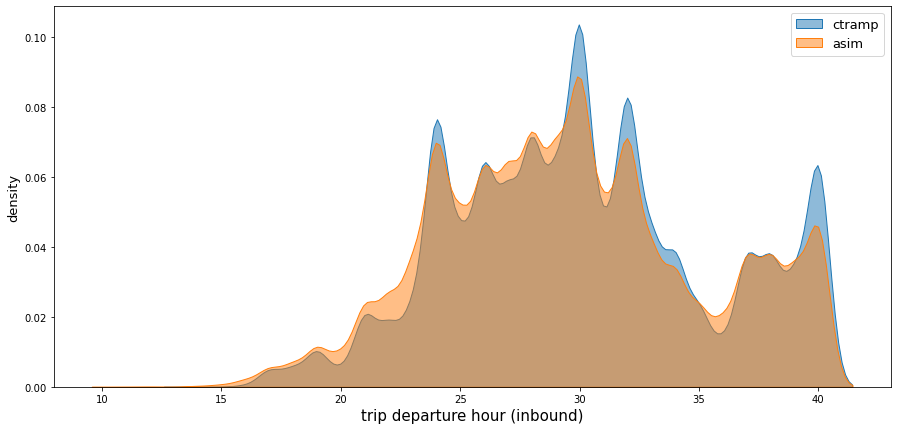

In [37]:
fig, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(data=ctramp_trips[ctramp_trips['inbound']], x='period', ax=ax, label='ctramp', alpha=0.5, shade=True)
sns.kdeplot(data=asim_trips[~asim_trips['outbound']], x='depart', ax=ax, label='asim', alpha=0.5, shade=True)
ax.legend(fontsize=13)
ax.set_ylabel('density', fontsize=13)
ax.set_xlabel('trip departure hour (inbound)', fontsize=15)

## Trip Destination 

### Trip ODs

In [38]:
asim_trips['dest_pseudomsa'] = asim_trips['destination'].map(mazs['pseudomsa'])
asim_trips['orig_pseudomsa'] = asim_trips['origin'].map(mazs['pseudomsa'])
ctramp_trips['dest_pseudomsa'] = ctramp_trips['destinationMGRA'].map(mazs['pseudomsa'])
ctramp_trips['orig_pseudomsa'] = ctramp_trips['originMGRA'].map(mazs['pseudomsa'])

asim_trip_ods = asim_trips.groupby(['orig_pseudomsa','dest_pseudomsa'])['trip_id'].count().reset_index()
asim_trip_ods.columns=['origin pMSA', 'destination pMSA', '# trips']
asim_trip_ods = asim_trip_ods.pivot(index='origin pMSA', columns='destination pMSA',values='# trips')
ctramp_trip_ods = ctramp_trips.groupby(['orig_pseudomsa','dest_pseudomsa'])['tripID'].count().reset_index()
ctramp_trip_ods.columns=['origin pMSA', 'destination pMSA', '# trips']
ctramp_trip_ods = ctramp_trip_ods.pivot(index='origin pMSA', columns='destination pMSA',values='# trips')

Text(0.5, 0.98, 'Trip OD Counts')

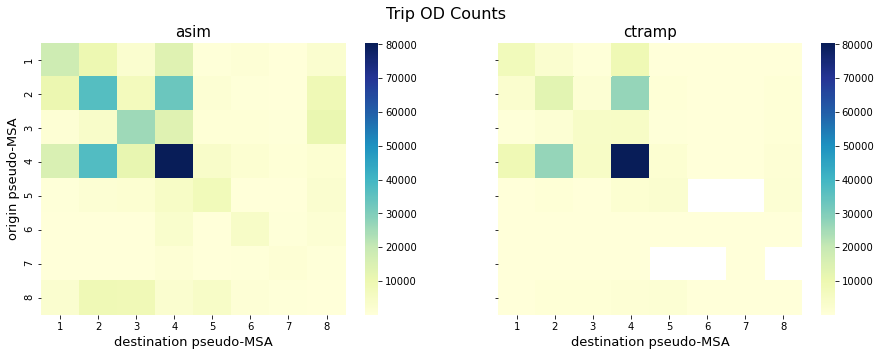

In [39]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
vmin = min(asim_trip_ods.min().min(), ctramp_trip_ods.min().min())
vmax = min(asim_trip_ods.max().max(), ctramp_trip_ods.max().max())

sns.heatmap(
    asim_trip_ods, ax=ax[0], cmap="YlGnBu", cbar=True,
    vmin=vmin, vmax=vmax,
#     norm=LogNorm()
)
g = sns.heatmap(
    ctramp_trip_ods, ax=ax[1],cmap="YlGnBu", cbar=True,
    vmin=vmin, vmax=vmax,
#     norm=LogNorm()
)
ax[0].set_title('asim', fontsize=15)
ax[0].set_ylabel('origin pseudo-MSA', fontsize=13)
ax[0].set_xlabel('destination pseudo-MSA', fontsize=13)
ax[1].set_title('ctramp', fontsize=15)
ax[1].set_ylabel('')
ax[1].set_xlabel('destination pseudo-MSA', fontsize=13)
fig.suptitle('Trip OD Counts', fontsize=16)

In [40]:
asim_trip_dest_tazs = asim_trips[asim_trips['trip_num'] != asim_trips['trip_count']].groupby('dest_taz')['trip_id'].count().reset_index()
asim_trip_dest_tazs.rename(columns={'trip_id':'asim_count'}, inplace=True)

ctramp_trip_dest_tazs = ctramp_trips[(~ctramp_trips['destinationIsTourDestination']) & (ctramp_trips['destPurp'] >= 0)].groupby('destinationTAZ')['tripID'].count().reset_index()
ctramp_trip_dest_tazs.rename(columns={'tripID':'ctramp_count', 'destinationTAZ':'dest_taz'}, inplace=True)

trip_dest_tazs = pd.merge(asim_trip_dest_tazs, ctramp_trip_dest_tazs, left_on='dest_taz',right_on='dest_taz', how='outer').fillna(0)

Text(0, 0.5, 'ctramp')

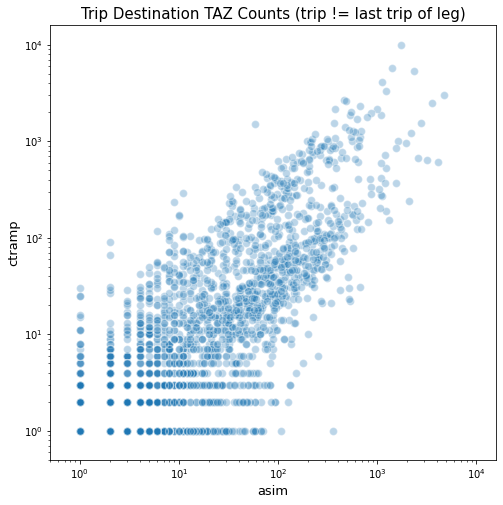

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
# ax.plot([-500, 16000], [-500, 16000], linewidth=1, alpha=0.7, c='k')
# ax.set_xscale('log')
# ax.set_yscale('log')
g = sns.scatterplot(data=trip_dest_tazs, x='asim_count', y='ctramp_count',ax=ax, marker='.',alpha=0.3, s=250)
ax.set_title('Trip Destination TAZ Counts (trip != last trip of leg)', fontsize=15)
g.set(xscale="log", yscale='log')
ax.set_xlim(.5, 16000)
ax.set_ylim(.5, 16000)

ax.set_xlabel('asim',fontsize=13)
ax.set_ylabel('ctramp', fontsize=13)

### Trip Distance

In [42]:
asim_uniq_ods = asim_trips[['orig_taz', 'dest_taz']].drop_duplicates()
asim_uniq_ods['sov_dist'] = skims['SOV_NT_M_DIST__EA'][asim_uniq_ods['orig_taz'].values - 1, asim_uniq_ods['dest_taz'].values - 1]

ctramp_uniq_ods = ctramp_trips[['originTAZ', 'destinationTAZ']].drop_duplicates()
ctramp_uniq_ods['sov_dist'] = skims['SOV_NT_M_DIST__EA'][ctramp_uniq_ods['originTAZ'].values - 1, ctramp_uniq_ods['destinationTAZ'].values - 1]

asim_trips_w_dist = asim_trips.merge(asim_uniq_ods, left_on=['orig_taz', 'dest_taz'], right_on=['orig_taz','dest_taz'])
ctramp_trips_w_dist = ctramp_trips.merge(ctramp_uniq_ods, left_on=['originTAZ','destinationTAZ'], right_on=['originTAZ','destinationTAZ'])

In [64]:
skims['SOV_NT_M_DIST__EA'][4993, 4993]

0.1204887330532074

In [57]:
skims['SOV_NT_M_DIST__EA'][1, 1]

1.009488821029663

In [60]:
skims['SOV_NT_M_DIST__EA'][1, 4993]

10.411242485046387

In [61]:
skims['SOV_NT_M_DIST__EA'][4993, 1]

9.989115715026855

In [43]:
asim_disc_mask = asim_trips_w_dist['trip_num'].between(1, asim_trips_w_dist['trip_count'], inclusive=False)
asim_disc_trips = asim_trips_w_dist[asim_disc_mask]

In [44]:
ctramp_disc_mask = (
    ctramp_trips_w_dist['destinationMGRA'] != ctramp_trips_w_dist['destinationMGRA_tour']) & (
    ctramp_trips_w_dist['destinationMGRA'] != ctramp_trips_w_dist['originMGRA_tour']) & (
    ctramp_trips_w_dist['originMGRA'] != ctramp_trips_w_dist['destinationMGRA_tour']) & (
    ctramp_trips_w_dist['originMGRA'] != ctramp_trips_w_dist['originMGRA_tour']
)
ctramp_disc_trips = ctramp_trips_w_dist[ctramp_disc_mask]

Text(0.5, 1.0, 'Trip Distance (all trips)')

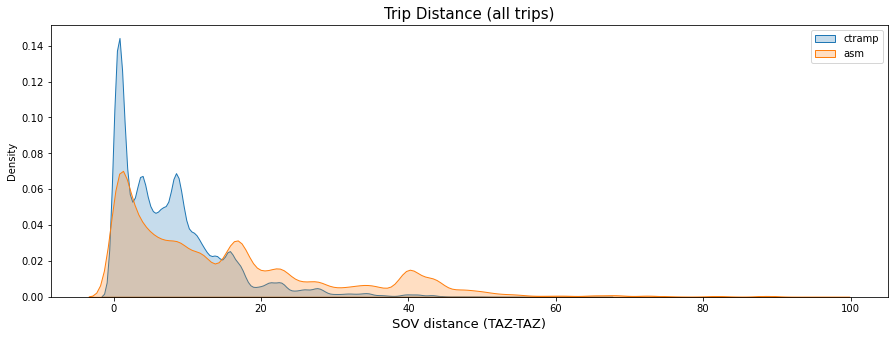

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(ctramp_trips_w_dist['sov_dist'], label='ctramp', ax=ax, fill=True)
sns.kdeplot(asim_trips_w_dist['sov_dist'], label='asm', ax=ax, fill=True)
ax.legend()
ax.set_xlabel('SOV distance (TAZ-TAZ)', fontsize=13)
ax.set_title('Trip Distance (all trips)', fontsize=15)

Text(0.5, 1.0, 'Trip Distance (non-tour-OD trips)')

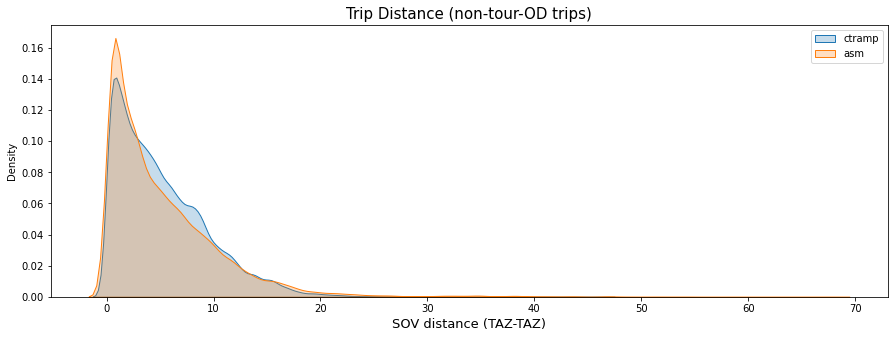

In [46]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(ctramp_disc_trips['sov_dist'], label='ctramp', ax=ax, fill=True)
sns.kdeplot(asim_disc_trips['sov_dist'], label='asm', ax=ax, fill=True)
ax.legend()
ax.set_xlabel('SOV distance (TAZ-TAZ)', fontsize=13)
ax.set_title('Trip Distance (non-tour-OD trips)', fontsize=15)

## Trip Mode

Text(0.5, 0, 'trip mode')

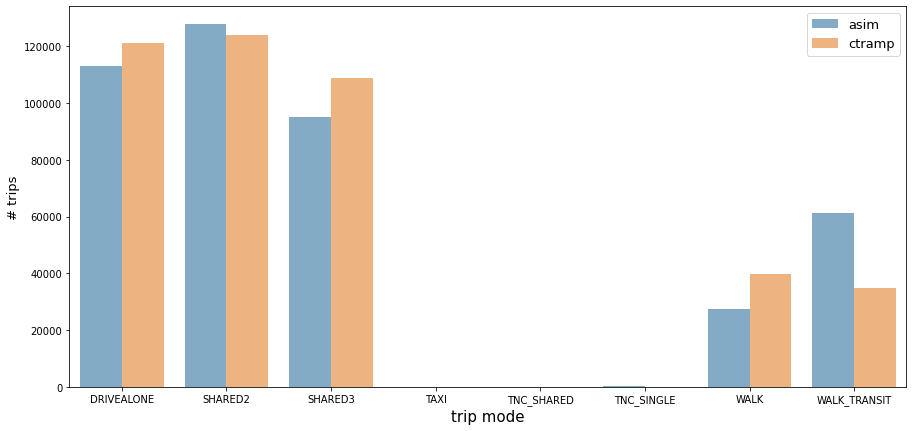

In [47]:
fig, ax = plt.subplots(figsize=(15,7))
trip_mode = asim_trips.groupby('trip_mode')['trip_id'].count()
trip_mode = pd.merge(
    trip_mode, ctramp_trips.groupby('trip_mode')['tripID'].count(),
    left_index=True, right_index=True, how='outer').reset_index()
trip_mode.columns = ['trip_mode','asim','ctramp']
trip_mode = trip_mode.melt(id_vars='trip_mode',var_name='source',value_name='num_trips')
g = sns.barplot(
    data=trip_mode, x='trip_mode', y='num_trips', 
    hue='source', ax=ax, alpha=0.6)
# g.set_yscale("log")
ax.legend(fontsize=13)
ax.set_ylabel('# trips', fontsize=13)
ax.set_xlabel('trip mode', fontsize=15)

###  Trip Mode by Tour Mode

In [48]:
trip_mode = asim_trips.groupby(['trip_mode','tour_mode'])['trip_id'].count().fillna(0)
trip_mode = pd.merge(
    trip_mode, ctramp_trips.groupby(['trip_mode','tour_mode'])['tripID'].count().fillna(0),
    left_index=True, right_index=True, how='outer').reset_index()
trip_mode.columns = ['trip_mode','tour_mode','asim','ctramp']
trip_mode_long = trip_mode.melt(id_vars=['trip_mode','tour_mode'],var_name='source',value_name='num_trips').fillna(0)

tour_mode_sums = trip_mode_long.groupby(['tour_mode', 'source'])['num_trips'].sum().reset_index()
tour_mode_sums.rename(columns={'num_trips': 'total_trips'}, inplace=True)
trip_mode_long = trip_mode_long.merge(tour_mode_sums, on=['tour_mode','source'])

trip_mode_long['pct_trips'] = trip_mode_long['num_trips'] / trip_mode_long['total_trips']

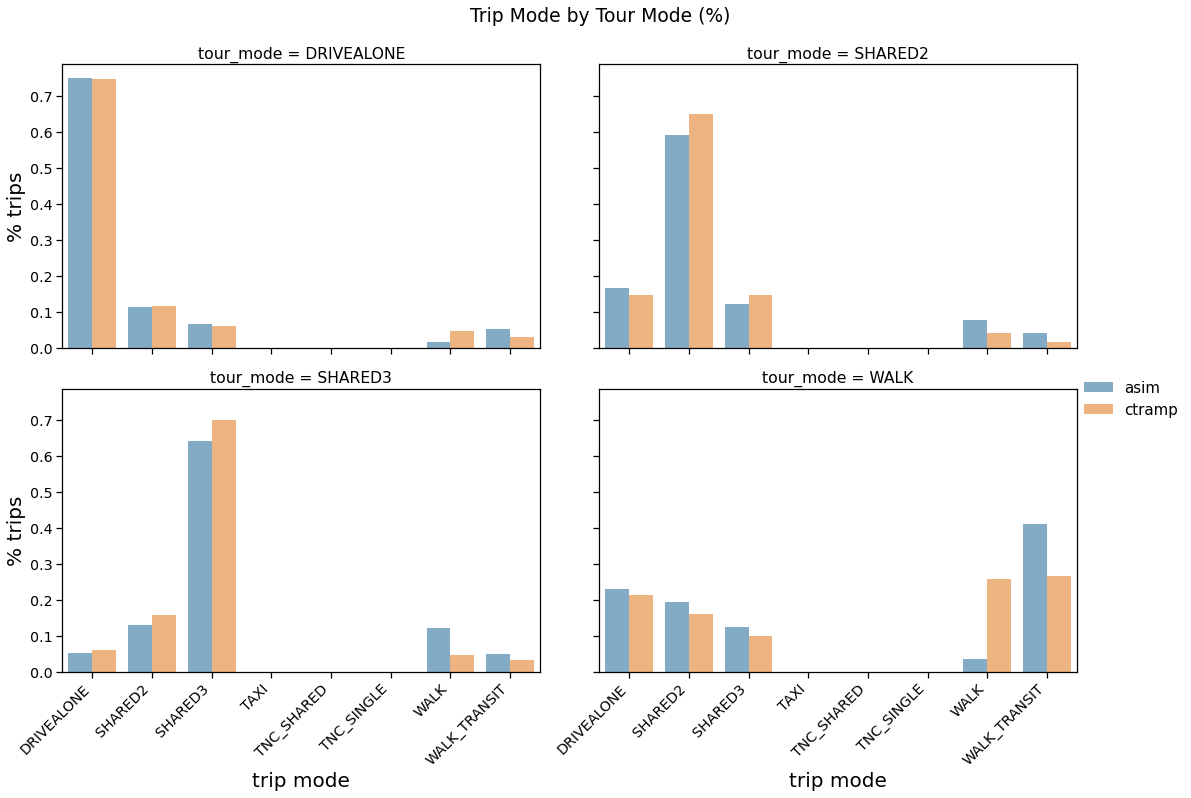

In [49]:
with sns.plotting_context("notebook",font_scale=1.3):
    g = sns.catplot(
        data=trip_mode_long, x='trip_mode', y='pct_trips', col='tour_mode', col_wrap=2, kind='bar',
        hue='source',alpha=0.6, aspect=1.5, facet_kws={'despine':False})
    # g.set_yscale("log")
    g._legend.set_title('')
    plt.setp(g._legend.get_texts(), fontsize=15)
    g.set_axis_labels("trip mode", "% trips", fontsize=20)
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Trip Mode by Tour Mode (%)')
    for ax in g.axes.ravel():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

### Trip Distance by Trip Mode

In [50]:
trip_dist_by_mode = pd.concat(
    (asim_trips_w_dist[['trip_mode','sov_dist','source']], ctramp_trips_w_dist[['trip_mode','sov_dist','source']]), names=['asim','ctramp'])

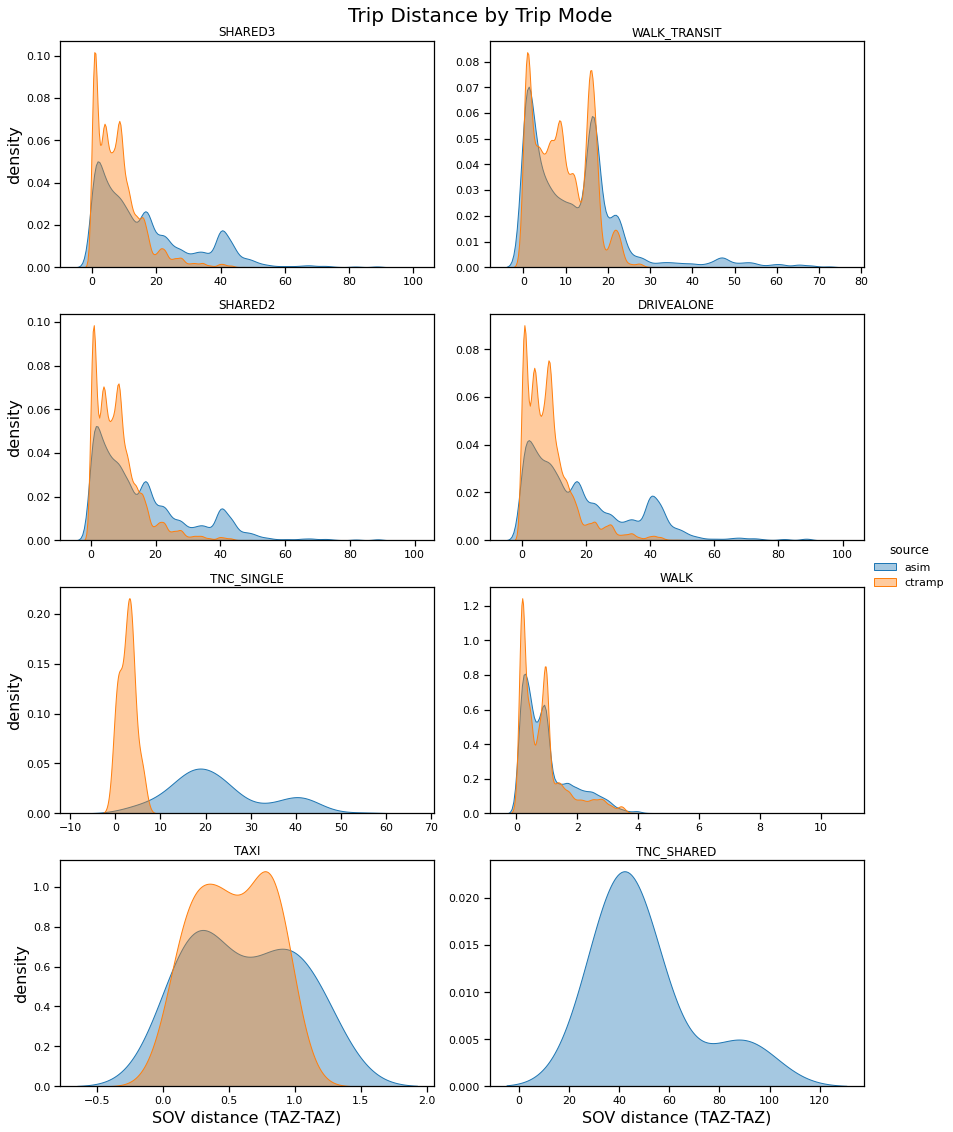

In [51]:
with sns.plotting_context("notebook",font_scale=1):
    g = sns.FacetGrid(trip_dist_by_mode, col="trip_mode", col_wrap=2, hue='source',
                      height=4, aspect=1.5,sharex=False, sharey=False, despine=False)
    g.map(sns.kdeplot, "sov_dist", fill=True, alpha=0.4)
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("SOV distance (TAZ-TAZ)", "density", fontsize=16)
    g.add_legend()
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle('Trip Distance by Trip Mode',fontsize=20)